# Búsqueda de insights
Este notebook busca encontrar insights relevantes sobre las features de mayor relevancia del dataset de propiedades de AirBnB de Chicago, luego de haberse hecho una limpieza básica en el primer notebook.

## Librerías

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import seaborn as sns

import string
import re

import nltk
from nltk.corpus import stopwords

from scipy.stats import ks_2samp, pearsonr, spearmanr

In [2]:
# Para poder visualizar todas las columnas de estadísticos
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

## Constantes

### Archivo de listings

In [3]:
LISTINGS_FILE = "/content/drive/MyDrive/UNIANDES/2023-II/CIENCIA DE DATOS APLICADA/taller_1/data/clean_listings.csv"

In [4]:
nltk.download('stopwords')
STOPWORDS = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Preprocesamiento

### Lectura de listings parcialmente limpios

In [5]:
df = pd.read_csv(LISTINGS_FILE)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8024 entries, 0 to 8023
Data columns (total 42 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           8024 non-null   int64  
 1   host_response_time           7160 non-null   object 
 2   host_response_rate           7160 non-null   float64
 3   host_acceptance_rate         7237 non-null   float64
 4   host_is_superhost            6393 non-null   object 
 5   host_identity_verified       8024 non-null   object 
 6   neighbourhood_cleansed       8024 non-null   object 
 7   latitude                     8024 non-null   float64
 8   longitude                    8024 non-null   float64
 9   property_type                8024 non-null   object 
 10  room_type                    8024 non-null   object 
 11  accommodates                 8024 non-null   int64  
 12  bathrooms_text               8011 non-null   object 
 13  bedrooms          

### Eliminación de listings donde el host no acepta nada
Si no acepta nada significa que no va a generar ganancia. Esto significa que tiene un acceptance rate de cero y todos los dias del año siguiente están disponibles.

In [7]:
df = df[~((df["host_acceptance_rate"] == 0) & (df["availability_365"] == 365))]

In [8]:
len(df)

8000

### Eliminación de latitud y longitud
La latitud y longitud no son magnitudes que se puedan asociar a la ganancia en términos de correlación, y como la información geográfica está en neighbourhood_cleansed, se eliminan estas columnas.

In [9]:
df.drop(
  columns=["latitude", "longitude"],
  inplace=True
)

<ipython-input-9-28aea70ed34e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(


In [10]:
len(df.columns)

40

### Eliminación de availabilities en el tiempo cercano
Como se asume la posibilidad de que existan patrones estacionales anuales, es decir, se asume que debido a la temporada del año puede que la propiedad solo se rente en ciertos meses, se eliminan las columnas de disponibilidad en 30, 60 y 90 días futuros. Se observa que hay correlaciones débiles y moderadas de la disponiblidad 365 con las otras variables.

<Axes: >

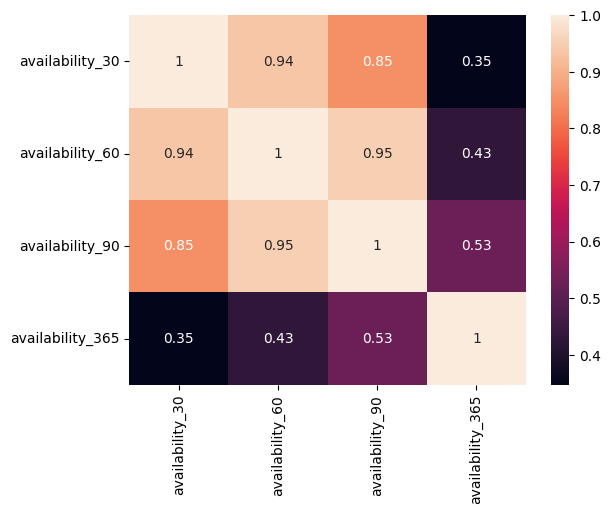

In [11]:
sns.heatmap(
    df[["availability_30", "availability_60", "availability_90", "availability_365"]].corr().abs(),
    annot=True
)

In [12]:
df.drop(
  columns=["has_availability", "availability_30", "availability_60", "availability_90"],
  inplace=True
)

In [13]:
len(df.columns)

36

### Eliminación de variables de número de reviews no agrupadas
Todos los conteos de number_of_reviews se resumen temporalmente agrupados con reviews_per_month. Esta variable tiene alta correlación con las demás de número de reviews.

<Axes: >

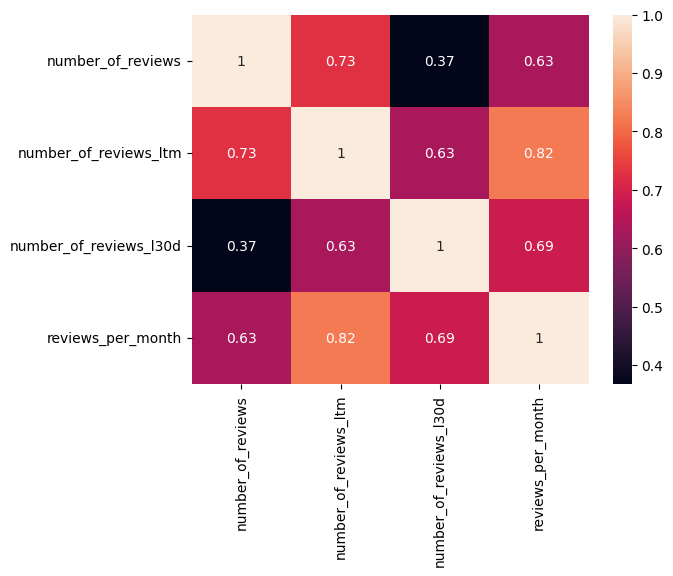

In [14]:
sns.heatmap(
  df[["number_of_reviews", "number_of_reviews_ltm", "number_of_reviews_l30d", "reviews_per_month"]].corr().abs(),
  annot=True
)

In [15]:
df.drop(
  columns=["number_of_reviews", "number_of_reviews_ltm", "number_of_reviews_l30d"],
  inplace=True
)

In [16]:
len(df.columns)

33

### Eliminación de columnas de review score redundantes

Aunque en un principio se asumió que el score de valor resumía más que el score de rating, al ver la correlación promedio se tiene que el score de rating es ligeramente mejor como variable representativa de los score de reviews.

<Axes: >

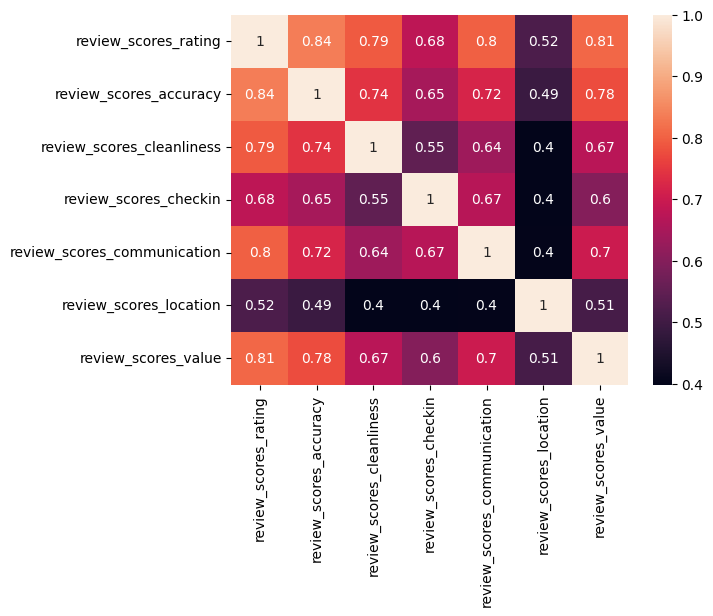

In [17]:
sns.heatmap(
    df[[
      'review_scores_rating',
      'review_scores_accuracy',
      'review_scores_cleanliness',
      'review_scores_checkin',
      'review_scores_communication',
      'review_scores_location',
      'review_scores_value'
    ]].corr().abs(),
    annot=True
)

In [18]:
df[[
  'review_scores_rating',
  'review_scores_accuracy',
  'review_scores_cleanliness',
  'review_scores_checkin',
  'review_scores_communication',
  'review_scores_location',
  'review_scores_value'
]].corr().abs().mean(axis=1)

review_scores_rating           0.776454
review_scores_accuracy         0.744506
review_scores_cleanliness      0.684015
review_scores_checkin          0.649022
review_scores_communication    0.703877
review_scores_location         0.531838
review_scores_value            0.723789
dtype: float64

In [19]:
df.drop(
  columns=[
  'review_scores_accuracy',
  'review_scores_cleanliness',
  'review_scores_checkin',
  'review_scores_communication',
  'review_scores_location',
  'review_scores_value'],
  inplace=True
)

In [20]:
len(df.columns)

27

### Eliminación de columnas redundantes de mínimo de noches

El promedio de mínimo de las noches está altamente correlacionado con todas las demás variables del mismo tipo.

<Axes: >

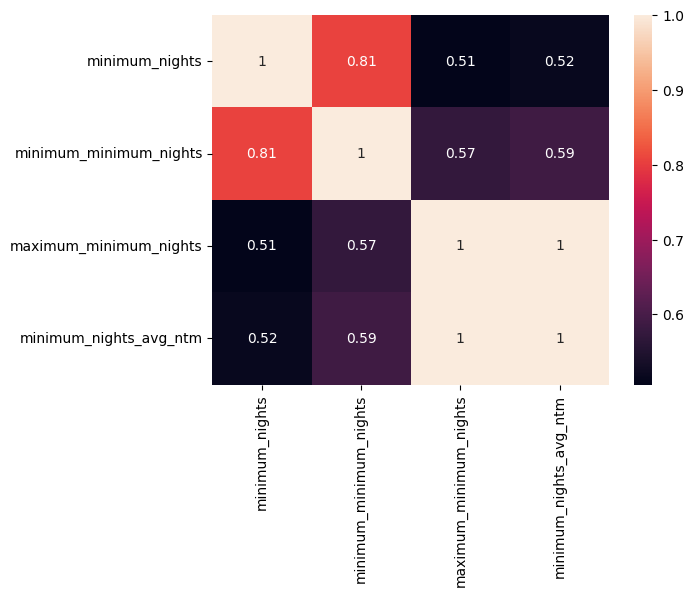

In [21]:
sns.heatmap(
    df[[
      'minimum_nights',
      'minimum_minimum_nights',
      'maximum_minimum_nights',
      'minimum_nights_avg_ntm'
    ]].corr().abs(),
    annot=True
)

In [22]:
df[[
      'minimum_nights',
      'minimum_minimum_nights',
      'maximum_minimum_nights',
      'minimum_nights_avg_ntm'
]].corr().abs().mean(axis=1)

minimum_nights            0.707603
minimum_minimum_nights    0.741883
maximum_minimum_nights    0.769479
minimum_nights_avg_ntm    0.775974
dtype: float64

In [23]:
df.drop(
  columns=[
    'minimum_nights',
    'minimum_minimum_nights',
    'maximum_minimum_nights'
  ],
  inplace=True
)

In [24]:
len(df.columns)

24

### Eliminación de columnas redundantes de máximo de noches

El promedio de máximo de las noches está altamente correlacionado con todas las demás variables del mismo tipo.

<Axes: >

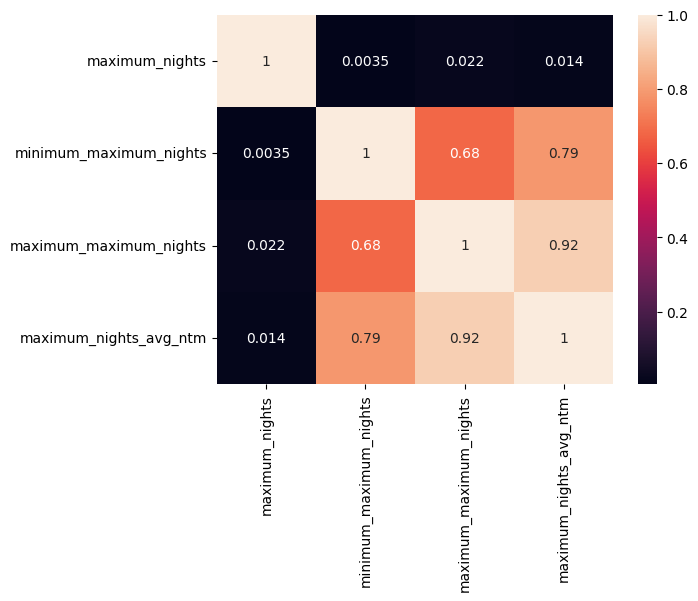

In [25]:
sns.heatmap(
    df[[
      'maximum_nights',
      'minimum_maximum_nights',
      'maximum_maximum_nights',
      'maximum_nights_avg_ntm'
    ]].corr().abs(),
    annot=True
)

In [26]:
df[[
      'maximum_nights',
      'minimum_maximum_nights',
      'maximum_maximum_nights',
      'maximum_nights_avg_ntm'
    ]].corr().abs().mean(axis=1)

maximum_nights            0.259715
minimum_maximum_nights    0.618859
maximum_maximum_nights    0.657094
maximum_nights_avg_ntm    0.681703
dtype: float64

In [27]:
df.drop(
  columns=[
    'maximum_nights',
    'minimum_maximum_nights',
    'maximum_maximum_nights'
  ],
  inplace=True
)

In [28]:
len(df.columns)

21

### Eliminación de bedrooms

Bedrooms y beds están altamente correlacionadas y se relacionan bastante en términos de negocio. Así que como beds tiene menos nulos se deja esta variable.

In [29]:
df[["bedrooms", "beds"]].isnull().sum()

bedrooms    1976
beds          60
dtype: int64

<Axes: >

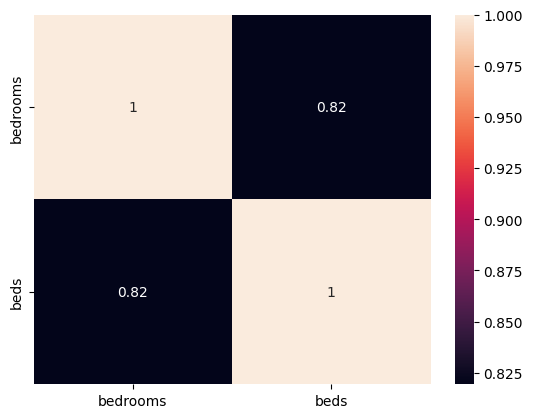

In [30]:
sns.heatmap(
  df[["bedrooms", "beds"]].corr(),
  annot=True
)

In [31]:
df.drop(columns=["bedrooms"], inplace=True)

In [32]:
len(df.columns)

20

### Transformación de amenities a categoricas binarias

Se toman las palabras más comunes de los amenities y se generan columnas binarias de tiene o no tiene el amenity.

In [33]:
df["amenities"] = df["amenities"].str.lower()
df["list_amenities"] = df["amenities"].apply(lambda x: eval(x))

In [34]:
all_text_amenities = []
for amenities in df["list_amenities"]:
  all_text_amenities.extend(amenities)

In [35]:
all_text_amenities = [
    re.sub("\s+" , " ", amenities).strip().split(" ")
    for amenities in all_text_amenities
]

In [36]:
amenities_words = [
    amenity for amenities in all_text_amenities
    for amenity in amenities
    if amenity not in STOPWORDS
]

In [37]:
pd.value_counts(amenities_words, normalize=True).to_dict()

{'alarm': 0.024481814881205318,
 'dryer': 0.021010695021743343,
 'free': 0.018467595012137523,
 'coffee': 0.018298272092163767,
 'allowed': 0.016438976182451957,
 'hot': 0.01515277323265132,
 '–': 0.015144632707652582,
 'parking': 0.014832036547701034,
 'water': 0.014555258697743935,
 'wifi': 0.012956459587991749,
 'smoke': 0.012691078473032883,
 'kitchen': 0.01238173852308083,
 'heating': 0.01224334959810228,
 'essentials': 0.01214729140311717,
 'carbon': 0.011790736408172436,
 'monoxide': 0.011790736408172436,
 'air': 0.011557917393208522,
 'conditioning': 0.011556289288208775,
 'hair': 0.011172056508268332,
 'iron': 0.011074370208283472,
 'refrigerator': 0.010968543383299875,
 'hangers': 0.01089039434331199,
 'fire': 0.010747121103334195,
 'shampoo': 0.010480111883375583,
 'microwave': 0.010291251703404856,
 'washer': 0.010289623598405108,
 'private': 0.010196821613419492,
 'dishes': 0.009838638513475011,
 'silverware': 0.009838638513475011,
 'bed': 0.009837010408475264,
 'linens': 

In [38]:
amenity_keys = ["alarm", "dryer", "coffee", "parking", "water", "wifi", "smoking", "kitchen"]

In [39]:
for amenity in amenity_keys:
  df[f"amenity_{amenity}"] = df["amenities"].str.contains(amenity)

In [40]:
df.drop(
  columns=["list_amenities", "amenities"],
  inplace=True
)

In [41]:
len(df.columns)

27

### Creación de columna de ganancia anual promedio

Se utiliza la fórmula descrita en el plan para crear esta columna. Hay muchas propiedades (10%) que generarían una ganancia diaria promedio menor a 1 dolar.

In [42]:
df["revenue"] = df["price"] * (df["availability_365"] / 365.0)

<Axes: ylabel='Frequency'>

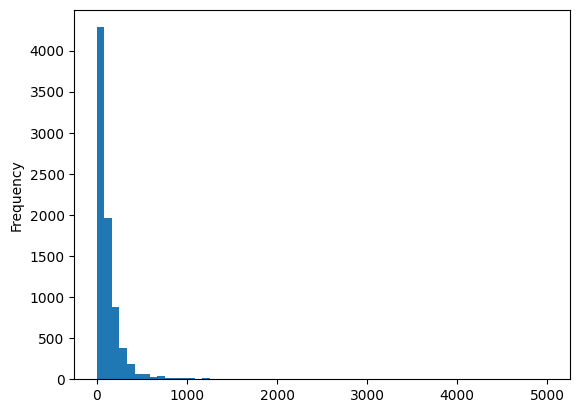

In [43]:
df["revenue"].plot(kind="hist", bins=60)

<Axes: ylabel='Frequency'>

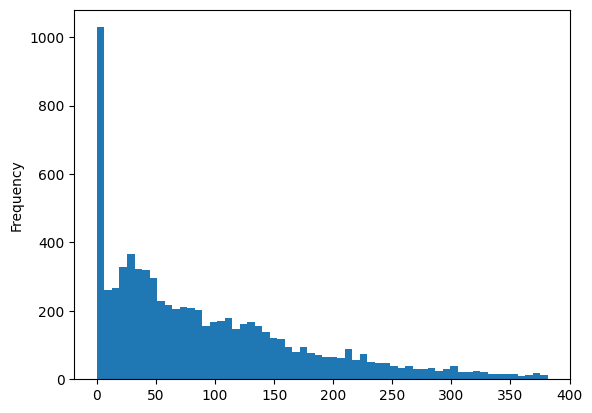

In [44]:
df[df["revenue"].between(df["revenue"].quantile(0.05), df["revenue"].quantile(0.95))]["revenue"].plot(kind="hist", bins=60)

In [45]:
sum(df["revenue"] < 1) / len(df)

0.103

In [46]:
df.drop(
  columns=["availability_365", "price"],
  inplace=True
)

In [47]:
len(df.columns)

26

### Binarización de ausencia de reviews

Si tiene o no tiene reviews podría indicar que la persona estuvo lo suficientemente satisfecha o insatisfecha para dejar un review, como lo visto en el notebook pasado, así que se crea una variable binaria para revisar esto.

In [48]:
df["has_review"] = ~df["review_scores_rating"].isnull()

### Análisis multivariado de Variables categóricas vs Ganancia

Ya teniendo las variables categóricas finales, se procede a visualizar la relación de las variables categóricas con la ganancia y se establecen hipótesis a ser testeadas por medio de test estadísticos.

#### host_response_time
- Algunas de las propiedades de los host que se demoran unos pocos días en responder o más generan más ganancia que la población general, pero en términos generales, como esta variable no es granular no se puede llegar a un punto atómico de definir cuántos días óptimos en responder son necesarios para generar la mayor ganancia.

#### host_is_superhost
- No se detecta ninguna influencia entre el hecho de que sea superhost y genere mayor ganancia.

#### host_is_verified
- No se detecta ninguna influencia entre el hecho de que sea verificado y genere mayor ganancia.

#### neighbourhood_cleansed
- Visualmente y ordenando por revenue medio se tiene que el barrio con propiedades más rentables es Near South Side, con una rentabilidad media de \$213 USD por propiedad. Seguido de Oakland y Edison Park donde 75% de las propiedades genera más de \$97 USD diarios.
- En Near South Side, se tiene un centro de comercio principal de Chicago, según Wikipedia, y esto también se refleja en el hecho de que se tengan 237 propiedades disponibles en este barrio.

#### property_type
- El tipo de propiedad que parece generar mayor rentabilidad son los botes, con una ganancia diaria media de \$ 400 USD, y como solo hay 3 de estos, existe campo abierto a crear competencia.
- Por valor de ganancia medio sigue una Villa completa, pero no se recomienda debido a su alta volatilidad, con un percentil 25 de tan solo 27 dólares.
- Finalmente están las habitaciones de hotel, donde la ganancia diaria media está encima de los \$ 300 USD, pero con un riesgo mucho menor al de las villas, con un percentil 75 de \$ 125 USD.

#### room_type
- Acorde a los percentiles 25 y 75 de la ganancia para cada categoría, NO se recomienda rentar cuartos, a menos de que estos sean de hotel, que como se vio anteriormente generan una gran rentabilidad.

#### bathrooms_text
- Las propiedades lujosas suelen tener mayores números de baños y esto se refleja en que tienen mayor ganancia, pero debido a que las categorías que generan mayor ganancia solamente tienen un ejemplo podría ser muy riesgoso guiarse por el número de baños.

#### instant_bookable
- El hecho de que se pueda agendar el mismo día no asegura una diferencia de ganancia significativa.

#### amenities
- La única amenity que genera una diferencia significativa de ganancia al tenerla es el wifi, donde se recomienda que la propiedad tenga esta conexión para que con un 50% de probabilidad (dada la mediana de revenue) se genere un valor de ganancia por encima de \$ 76 USD. Sin wifi, se tiene un 75% de probabilidad, percentil 75 de no wifi, de ganar hasta \$ 69 USD diarios máximo.

#### has_review
- Contrario a la hipótesis planteada respecto de tener o no tener reviews, un cierto porcentaje de propiedades sin review suele tener mayor ganancia que los que tienen revenue, comparando percentiles 50 y 75 respectivamente.

In [49]:
CATEGORICAL_VARIABLES = [
    "host_response_time",
    "host_is_superhost",
    "host_identity_verified",
    "neighbourhood_cleansed",
    "property_type",
    "room_type",
    "bathrooms_text",
    "instant_bookable",
    "amenity_alarm",
    "amenity_dryer",
    "amenity_coffee",
    "amenity_parking",
    "amenity_water",
    "amenity_wifi",
    "amenity_smoking",
    "amenity_kitchen",
    "has_review"
]

,count,mean,std,min,25%,50%,75%,max
host_response_time,,,,,,,,
within an hour,6037.0,136.649302,226.776009,0.0,34.958904,86.224658,161.030137,5006.989041
within a few hours,665.0,106.271319,131.844817,0.0,31.808219,67.463014,140.613699,1446.027397
within a day,330.0,109.045064,139.213373,0.0,25.150685,67.278082,134.580822,984.602740
a few days or more,105.0,307.695838,497.235095,0.0,28.109589,60.821918,257.753425,2445.676712


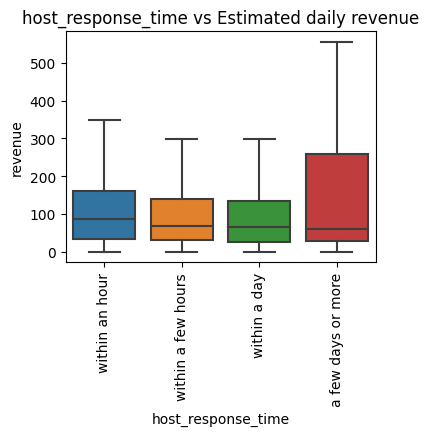

,count,mean,std,min,25%,50%,75%,max
host_is_superhost,,,,,,,,
f,3881.0,141.290490,199.819562,0.0,34.273973,106.819178,175.775342,4986.301370
t,2510.0,151.898699,270.390536,0.0,38.855479,84.078082,165.275342,4351.775342


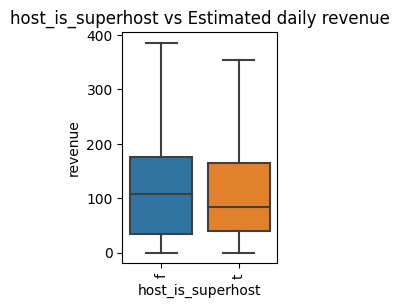

,count,mean,std,min,25%,50%,75%,max
host_identity_verified,,,,,,,,
t,7114.0,126.749514,225.450834,0.0,28.419178,75.534247,152.558219,5006.989041
f,886.0,129.020724,215.817486,0.0,22.745205,68.487671,143.030137,1849.315068


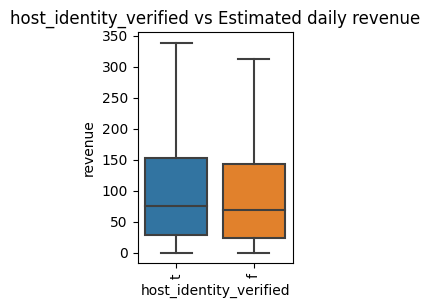

,count,mean,std,min,25%,50%,75%,max
neighbourhood_cleansed,,,,,,,,
Near South Side,237.0,198.638032,129.104452,0.000000,119.465753,213.600000,244.682192,815.506849
Oakland,12.0,141.061644,75.426773,12.328767,105.645890,151.021918,200.758904,244.520548
Edison Park,2.0,141.684932,123.749499,54.180822,97.932877,141.684932,185.436986,229.189041
Ohare,14.0,128.622896,82.670679,6.271233,57.328767,141.586301,190.222603,250.000000
Near North Side,960.0,200.093841,305.726487,0.000000,54.652055,136.623288,214.235616,5006.989041
Clearing,17.0,165.574214,122.714272,0.000000,98.383562,135.369863,164.219178,406.109589
Loop,416.0,154.442242,237.734373,0.000000,41.589041,131.719178,181.821918,3074.936986
Hegewisch,5.0,111.671781,66.883247,40.832877,58.386301,119.104110,130.191781,209.843836
Washington Heights,7.0,129.042661,91.717911,10.956164,66.824658,110.000000,197.569863,253.553425


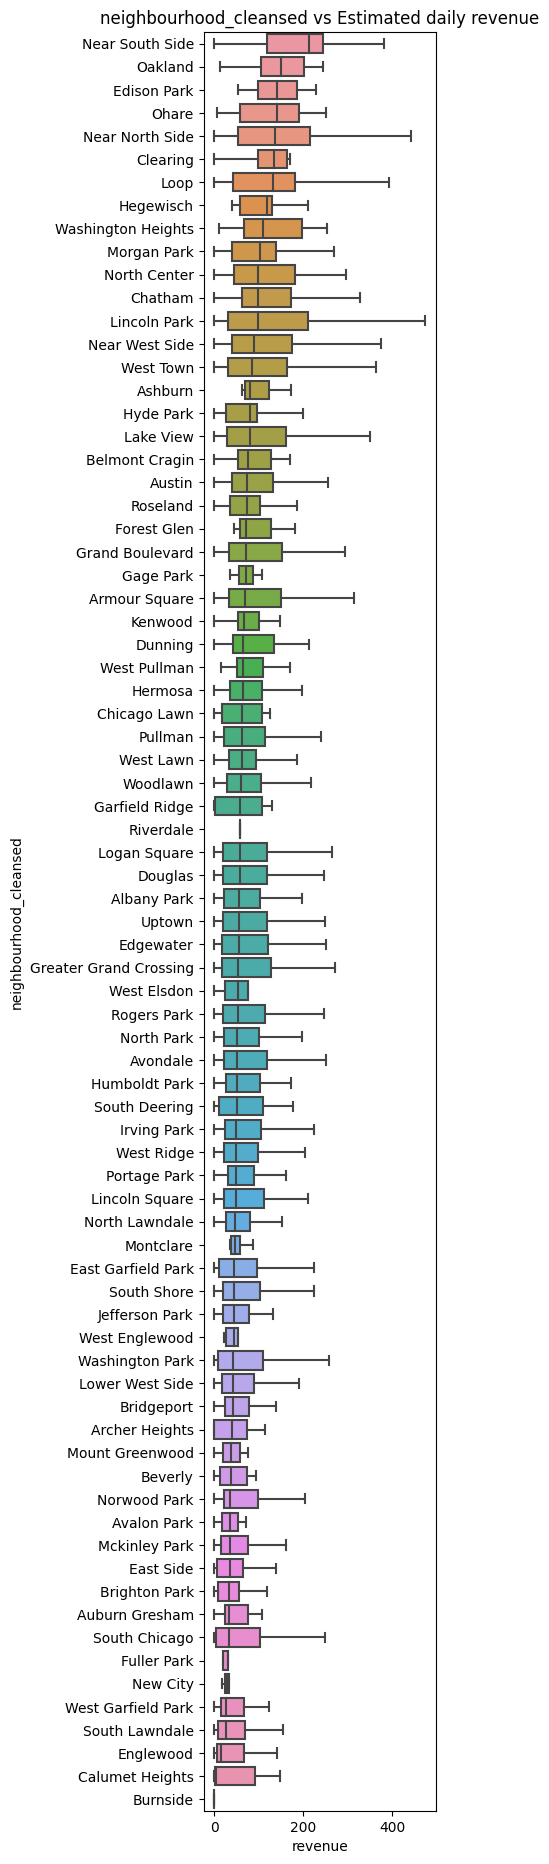

,count,mean,std,min,25%,50%,75%,max
property_type,,,,,,,,
Boat,3.0,384.140639,81.486379,295.890411,347.945205,400.000000,428.265753,456.531507
Entire villa,4.0,1294.482877,2142.089273,0.000000,27.805479,351.595890,1618.273288,4474.739726
Room in hotel,98.0,368.106094,308.314043,0.000000,174.175342,310.576712,521.216438,1212.142466
Room in aparthotel,3.0,194.031050,168.042380,0.000000,144.780822,289.561644,291.046575,292.531507
Private room in villa,1.0,287.531507,NaN,287.531507,287.531507,287.531507,287.531507,287.531507
Entire serviced apartment,178.0,194.143851,149.853228,0.000000,80.353425,156.250685,263.136301,850.000000
Entire vacation home,13.0,211.696101,154.486591,0.000000,93.424658,151.027397,290.739726,449.917808
Entire home,587.0,253.939483,353.206250,0.000000,70.838356,148.397260,326.367123,5006.989041
Castle,1.0,146.035616,NaN,146.035616,146.035616,146.035616,146.035616,146.035616


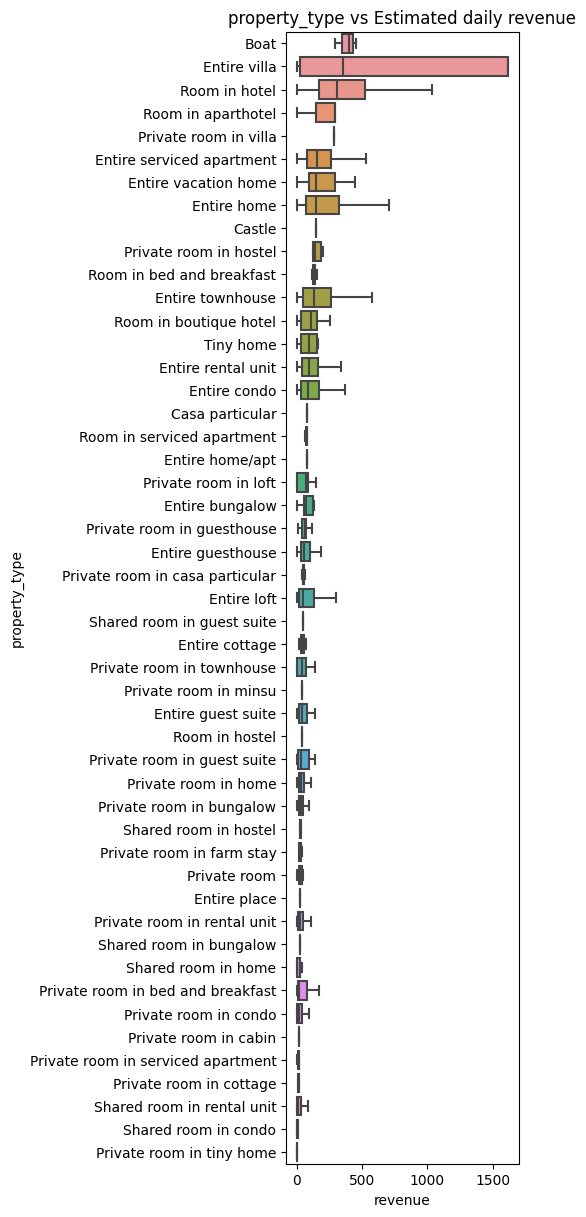

,count,mean,std,min,25%,50%,75%,max
room_type,,,,,,,,
Entire home/apt,6198.0,146.202456,243.584569,0.0,38.378767,97.464384,172.602740,5006.989041
Hotel room,48.0,97.389612,70.063103,0.0,41.884932,77.594521,154.719863,292.531507
Private room,1670.0,61.850701,121.052387,0.0,9.863014,31.457534,60.475342,1212.142466
Shared room,84.0,22.383431,25.245676,0.0,3.012329,22.072603,28.867123,145.000000


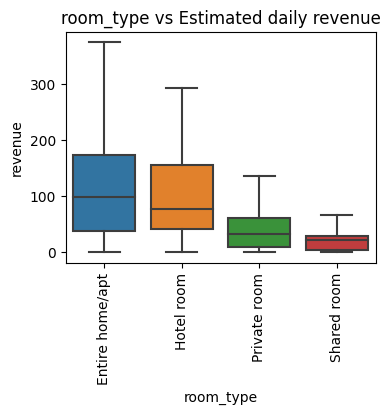

,count,mean,std,min,25%,50%,75%,max
bathrooms_text,,,,,,,,
8.5 baths,1.0,4351.775342,NaN,4351.775342,4351.775342,4351.775342,4351.775342,4351.775342
6.5 baths,2.0,2908.880822,2967.173099,810.772603,1859.826712,2908.880822,3957.934932,5006.989041
8 baths,2.0,2421.524658,11.830962,2413.158904,2417.341781,2421.524658,2425.707534,2429.890411
7.5 baths,2.0,2133.424658,1051.167505,1390.136986,1761.780822,2133.424658,2505.068493,2876.712329
7 baths,5.0,1560.410959,1228.051936,62.465753,561.232877,2015.873973,2081.934247,3080.547945
5.5 baths,7.0,1897.887671,1034.580473,748.835616,956.552055,1796.917808,2901.830137,3022.695890
10 baths,2.0,1777.961644,1834.200119,480.986301,1129.473973,1777.961644,2426.449315,3074.936986
6 baths,13.0,1390.130875,1413.793111,226.849315,354.775342,803.835616,1817.293151,4474.739726
5 baths,8.0,783.003082,706.781901,165.479452,220.473288,630.086301,962.054795,2245.235616


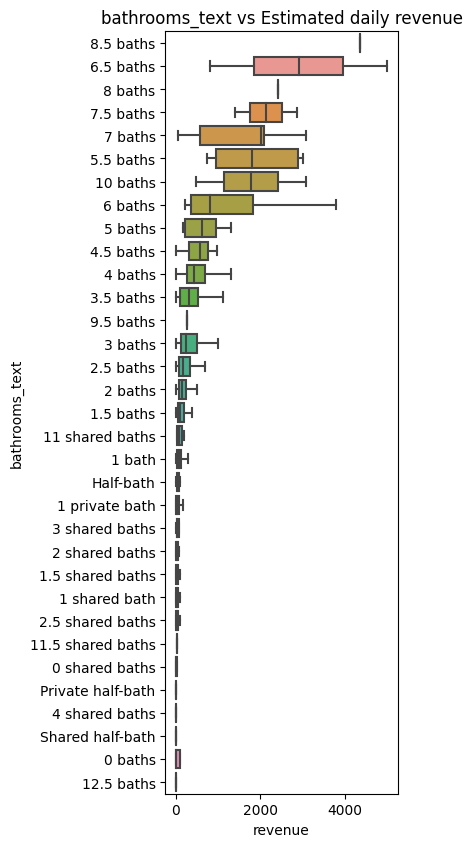

,count,mean,std,min,25%,50%,75%,max
instant_bookable,,,,,,,,
t,2095.0,177.691299,332.074581,0.0,33.430137,85.890411,205.986301,5006.989041
f,5905.0,109.016957,166.950615,0.0,25.698630,70.756164,140.383562,4986.301370


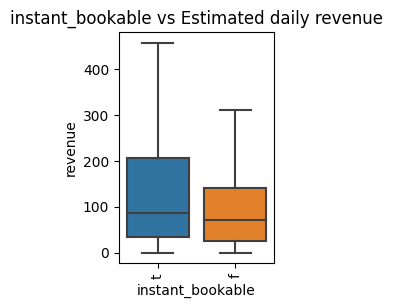

,count,mean,std,min,25%,50%,75%,max
amenity_alarm,,,,,,,,
True,7823.0,124.815503,218.265885,0.0,28.130137,75.216438,150.964384,5006.989041
False,177.0,223.597291,401.955590,0.0,13.430137,46.684932,176.383562,1653.000000


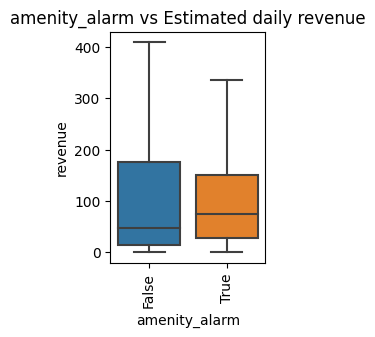

,count,mean,std,min,25%,50%,75%,max
amenity_dryer,,,,,,,,
True,7416.0,129.706841,228.295542,0.0,28.970548,77.193151,154.750685,5006.989041
False,584.0,92.641213,163.368951,0.0,11.901370,49.713699,110.273973,1618.065753


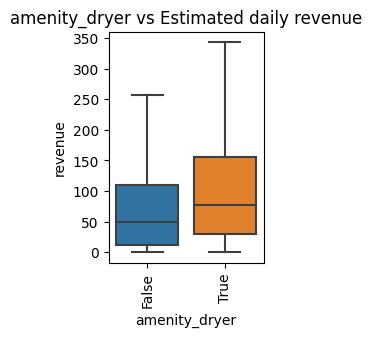

,count,mean,std,min,25%,50%,75%,max
amenity_coffee,,,,,,,,
True,6553.0,135.697204,236.860643,0.0,31.682192,82.232877,158.654795,5006.989041
False,1447.0,87.618955,149.777599,0.0,4.835616,43.780822,117.665753,2445.676712


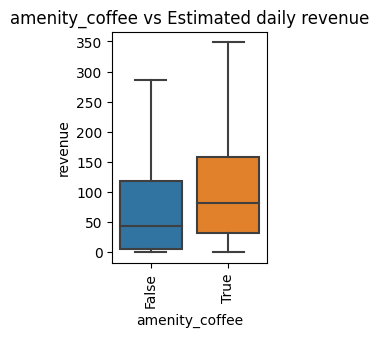

,count,mean,std,min,25%,50%,75%,max
amenity_parking,,,,,,,,
False,1898.0,129.441549,193.899473,0.0,29.746575,87.808219,157.284932,2245.235616
True,6102.0,126.241944,233.074369,0.0,26.845890,71.123288,149.291781,5006.989041


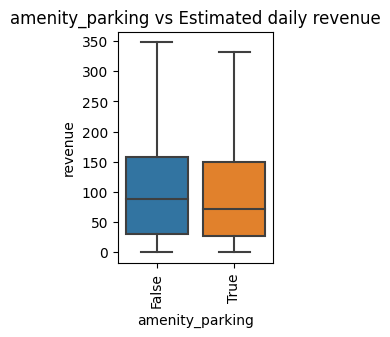

,count,mean,std,min,25%,50%,75%,max
amenity_water,,,,,,,,
True,6598.0,125.484735,216.733911,0.0,28.767123,75.972603,153.132877,5006.989041
False,1402.0,134.137033,257.359449,0.0,21.239726,70.756164,147.141781,4986.301370


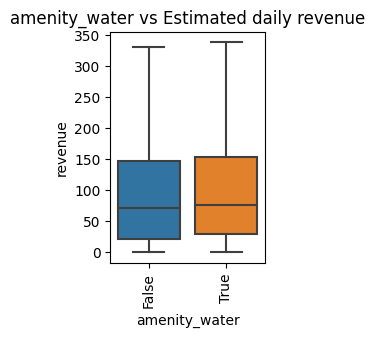

,count,mean,std,min,25%,50%,75%,max
amenity_wifi,,,,,,,,
True,7856.0,127.876804,225.020971,0.0,27.634932,76.065753,152.784247,5006.989041
False,144.0,79.223801,181.230483,0.0,24.301370,45.301370,69.479452,1618.065753


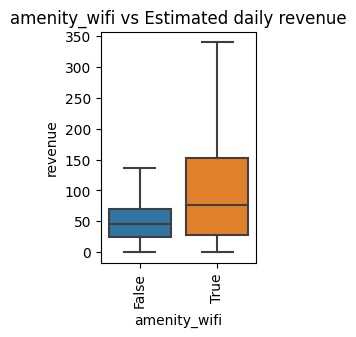

,count,mean,std,min,25%,50%,75%,max
amenity_smoking,,,,,,,,
True,220.0,126.485778,197.328965,0.0,23.180137,75.616438,207.760959,2445.676712
False,7780.0,127.015621,225.121515,0.0,27.797260,74.745205,150.465068,5006.989041


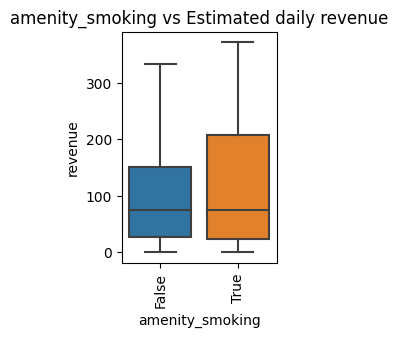

,count,mean,std,min,25%,50%,75%,max
amenity_kitchen,,,,,,,,
True,7489.0,126.451482,224.575445,0.0,28.405479,76.120548,151.446575,5006.989041
False,511.0,135.055288,221.752459,0.0,22.152055,50.531507,152.160274,1618.065753


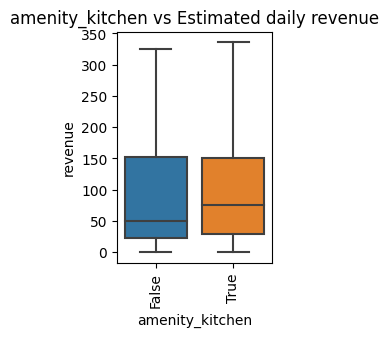

,count,mean,std,min,25%,50%,75%,max
has_review,,,,,,,,
False,1546.0,166.730440,300.193582,0.0,39.095890,116.656164,188.111644,4986.301370
True,6454.0,117.484218,200.924065,0.0,26.038356,67.795890,140.262329,5006.989041


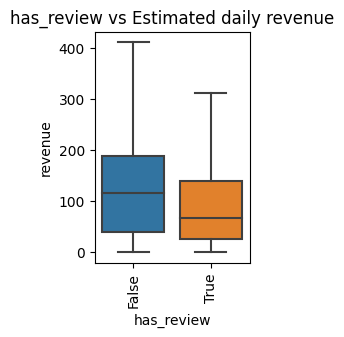

In [50]:
for col in CATEGORICAL_VARIABLES:
  df["avg_revenue_col"] = df.groupby(col)["revenue"].transform("median")
  df.sort_values("avg_revenue_col", ascending=False, inplace=True)
  display(
      df.groupby(col)["revenue"].describe().sort_values("50%", ascending=False)
  )
  n_cats = df[col].nunique()
  if n_cats < 10:
    plt.figure(figsize=(n_cats * 1, 3))
    plt.title(f"{col} vs Estimated daily revenue")
    sns.boxplot(
      df,
      x=col,
      showfliers=False,
      y="revenue"
    )

    plt.xticks(rotation=90)
    plt.show()
    plt.close()
  else:
    plt.figure(figsize=(3, n_cats * 0.3))
    plt.title(f"{col} vs Estimated daily revenue")
    sns.boxplot(
      df,
      y=col,
      showfliers=False,
      x="revenue"
    )
    plt.show()
    plt.close()
  df.drop(columns=["avg_revenue_col"], inplace=True)

#### Mejores categorías vs el resto
Se compara estadísticamente si hay diferencia significativa entre las mejores categorías seleccionadas y el resto por medio de un test de Kolmogorov-Smirnov. Se usa este test porque es no paramétrico y no requiere el supuesto de que las distribuciones sean normales.

Se puede observar que las mejores categorías tienen un percentil 25 de revenue cercano o por encima del percenitl 75 de las otras categorías generando una mejor ganancia.

Respecto del test de Kolmogorov, si el pvalue es menor a 0.05, se rechaza la hipótesis nula de que los datos son generados por la misma distribución. Es decir, para todas las categorías tomadas como las mejores, se tiene que la distribución de los mejores es diferente a la de las demás categorías.

In [51]:
best_categories = {
  "neighbourhood_cleansed": ["Near South Side", "Oakland", "Edison Park"],
  "property_type": ["Boat", "Room in hotel"],
  "room_type": ["Entire home/apt", "Hotel room"],
  "amenity_wifi": [True]
}

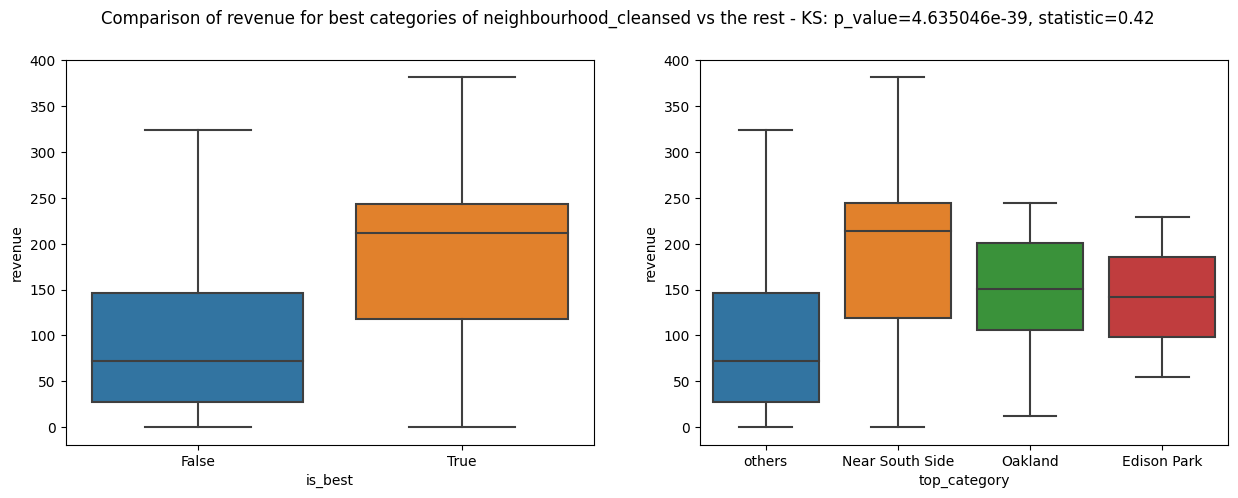

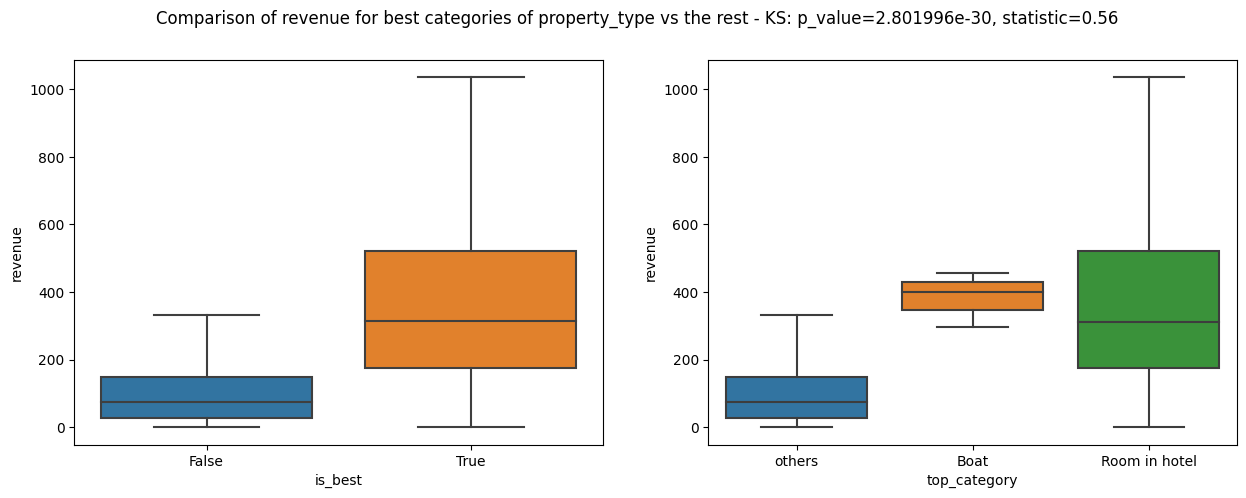

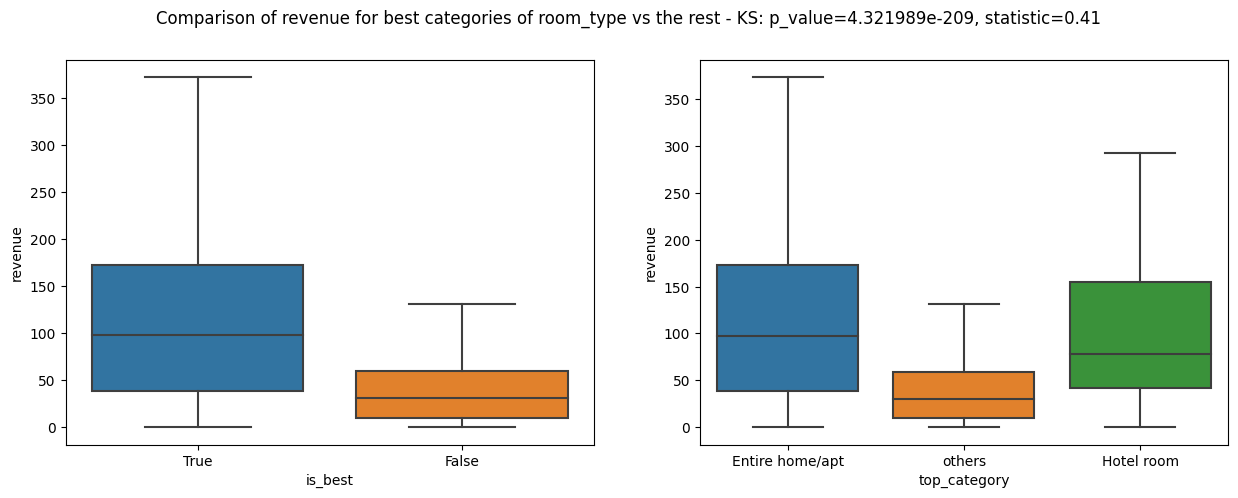

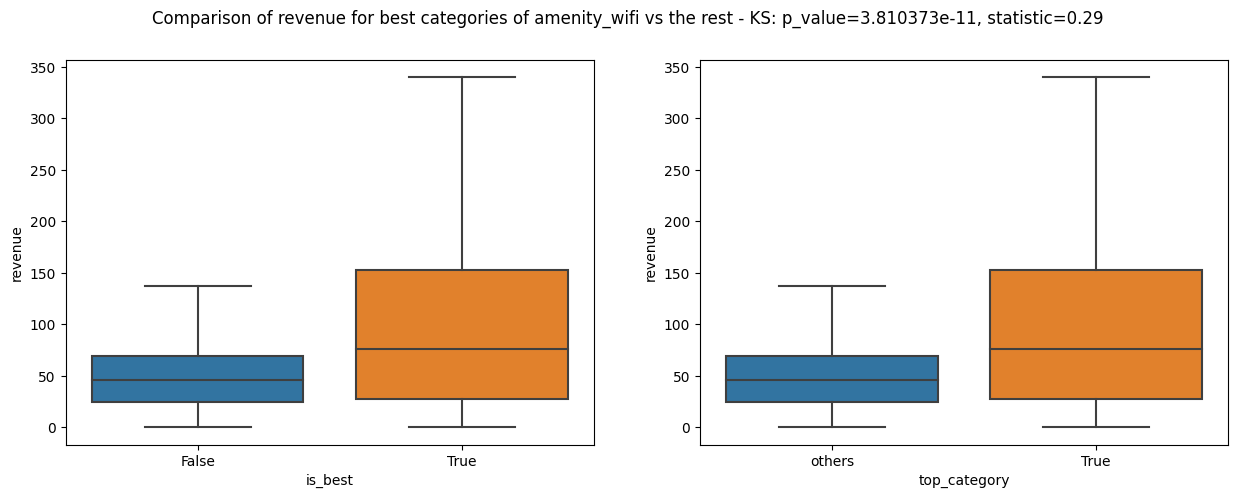

In [52]:
for col, best_cats in best_categories.items():
  df["is_best"] = df[col].isin(best_cats).astype(str)
  df["top_category"] = np.where(
      df["is_best"] == "True",
      df[col],
      "others"
  )
  best_revenues = df[df["is_best"] == "True"]["revenue"]
  other_revenues = df[df["is_best"] == "False"]["revenue"]

  ks_result = ks_2samp(best_revenues, other_revenues)

  ks_pvalue = ks_result.pvalue
  ks_statistic = ks_result.statistic

  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
  fig.suptitle(f"Comparison of revenue for best categories of {col} vs the rest - KS: p_value={ks_pvalue:e}, statistic={ks_statistic:.2f}")
  sns.boxplot(
    df,
    y="revenue",
    showfliers=False,
    x="is_best",
    ax=ax1
  )
  sns.boxplot(
    df,
    y="revenue",
    showfliers=False,
    x="top_category",
    ax=ax2
  )

  plt.show()
  plt.close()
  df.drop(columns=["is_best", "top_category"], inplace=True)

### Maximización de revenue con mejores categorías

Se seleccionan pares de columnas seleccionando propiedades que correspondan a lo mejor de las dos columnas y se calcula el revenue promedio con un heatmap para determinar qué combinaciones de features categóricas generan mejor revenue promedio. De estas matrices se puede observar que:

- No hay propiedades de tipo habitación de hotel y bote en los mejores barrios, por lo que podría ser una oportunidad de negocio comprar habitaciones de hotel o crear un hotel para generar un gran margen de ganancia.
- Las habitaciones de hotel con wifi generan la mayor rentabilidad de combinaciones de variables categóricas, generando una ganancia promedio de \$ 350 USD por día.

In [53]:
col_revenue_stats = []
col_counts = []
for col1, best_cats1 in best_categories.items():
  col1_revenue_stats = []
  col1_counts = []
  for col2, best_cats2 in best_categories.items():
    df_best_of_both = df[
        df[col1].isin(best_cats1) &
        df[col2].isin(best_cats2)
    ]
    avg_revenue = df_best_of_both["revenue"].mean()
    col1_revenue_stats.append(avg_revenue)
    col1_counts.append(len(df_best_of_both))
  col_revenue_stats.append(col1_revenue_stats)
  col_counts.append(col1_counts)

df_revenue_stats_cat = pd.DataFrame(col_revenue_stats)
df_revenue_stats_cat.index = best_categories.keys()
df_revenue_stats_cat.columns = best_categories.keys()

df_revenue_counts_cat = pd.DataFrame(col_counts)
df_revenue_counts_cat.index = best_categories.keys()
df_revenue_counts_cat.columns = best_categories.keys()

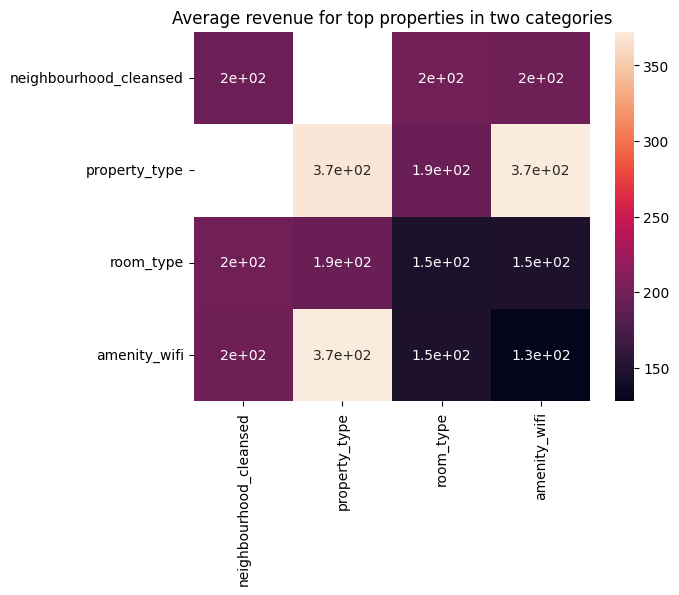

In [54]:
plt.title("Average revenue for top properties in two categories")
sns.heatmap(df_revenue_stats_cat, annot=True)
plt.show()

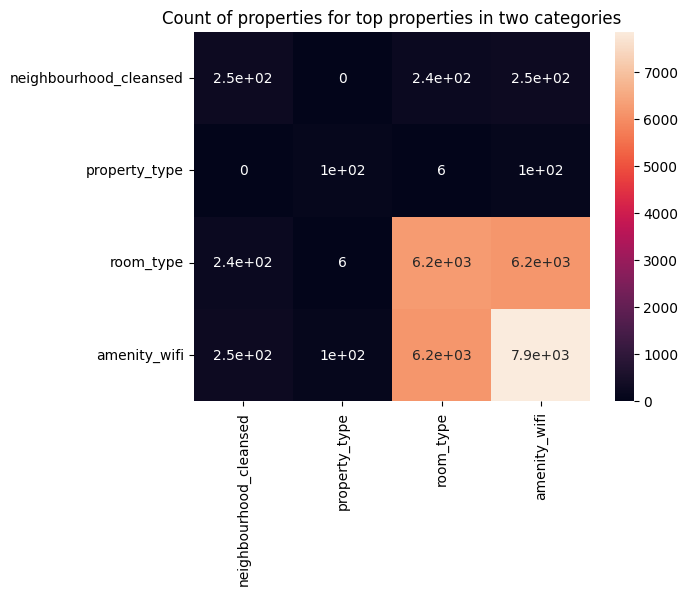

In [55]:
plt.title("Count of properties for top properties in two categories")
sns.heatmap(df_revenue_counts_cat, annot=True)
plt.show()

### Análisis multivariado de Variables cuantitativas vs Ganancia

Por medio de scatterplots y correlaciones se establece si existe alguna relación entre la ganancia y las variables cuantitativas, ya sea discretas o continuas.

#### host_response_rate
- No hay correlación

#### host_acceptance_rate
- No hay correlación

#### accommodates
- Hay una moderada correlación de 0.40, lo que quiere decir que entre más huéspedes permita, más revenue se puede obtener. Esta correlación podría ser un poco engañosa por la forma en la que se agrupan los valores en magnitudes bajas.

#### beds
- Al igual que accommodates, hay una moderada correlación de 0.40, indicando que más camas generan mayor ganancia. Esta correlación podría ser un poco engañosa por la forma en la que se agrupan los valores en magnitudes bajas.

#### minimum_nights_avg_ntm
- No hay correlación

#### maximum_nights_avg_ntm
- No hay correlación

#### review_scores_rating
- No hay correlación

#### reviews_per_month
- No hay correlación

In [56]:
NUMERICAL_VARIABLES = [
 'host_response_rate',
 'host_acceptance_rate',
 'accommodates',
 'beds',
 'minimum_nights_avg_ntm',
 'maximum_nights_avg_ntm',
 'review_scores_rating',
 'reviews_per_month'
]

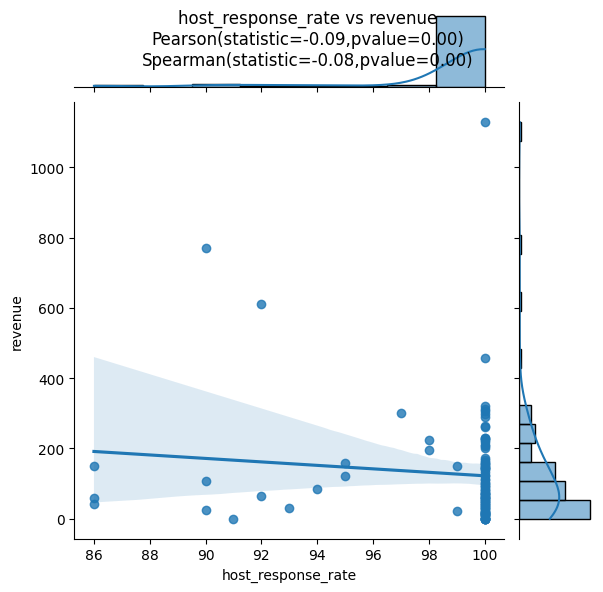

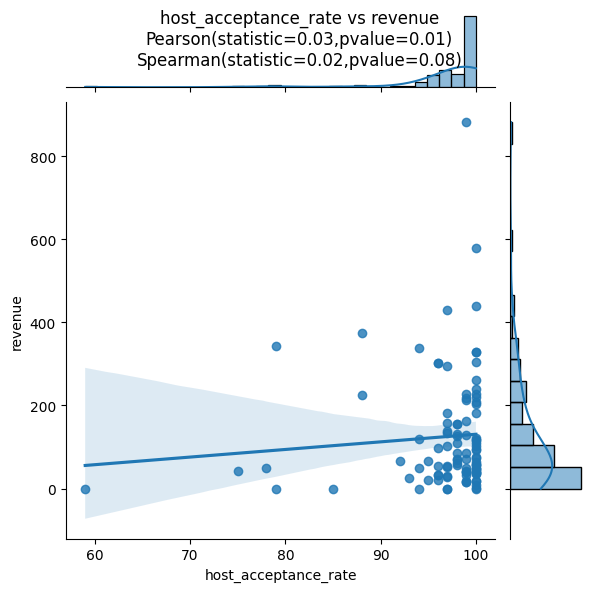

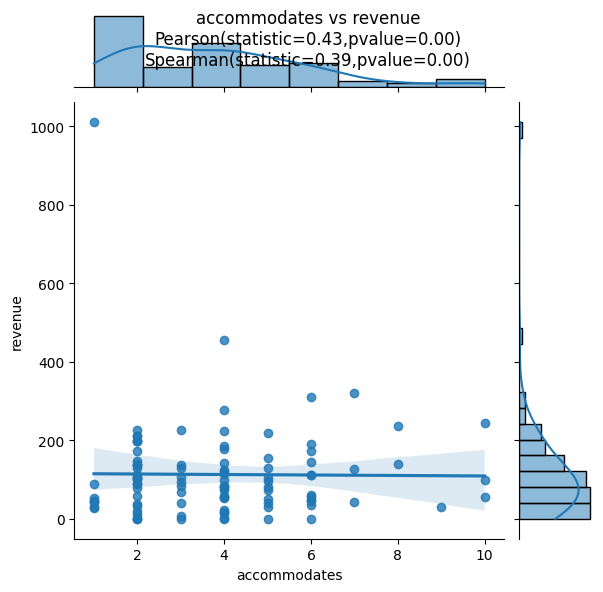

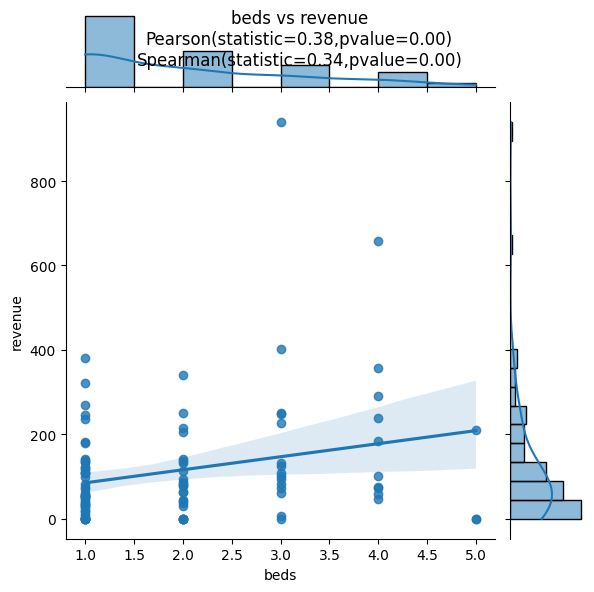

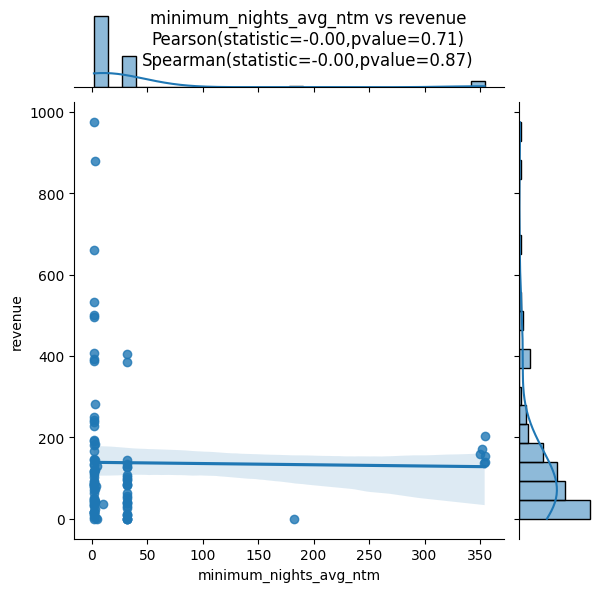

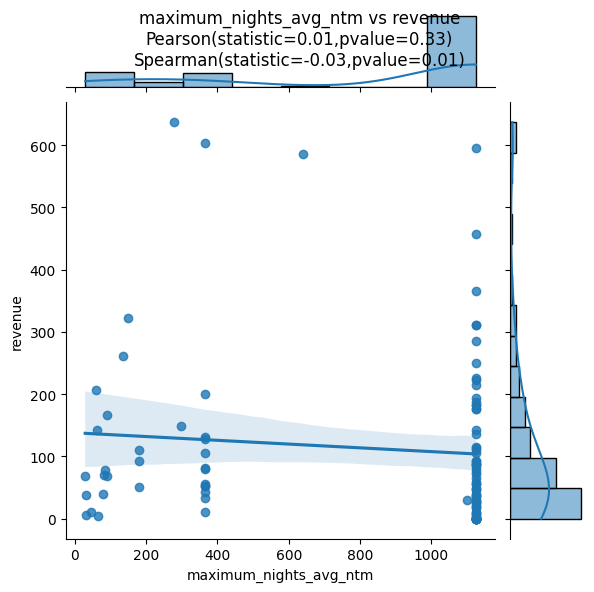

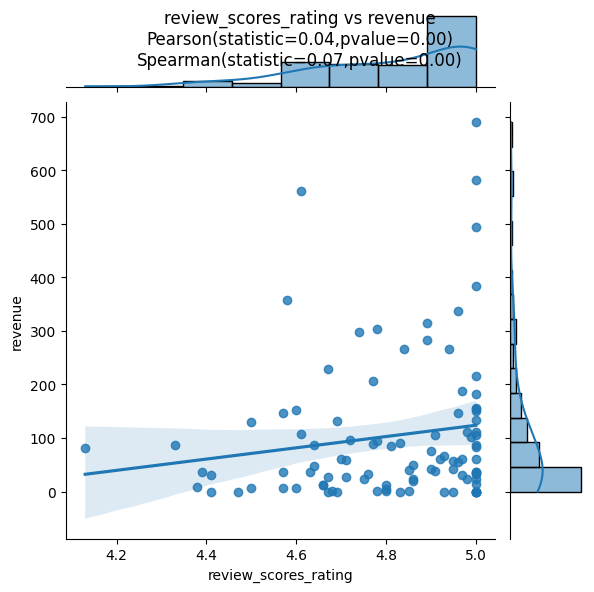

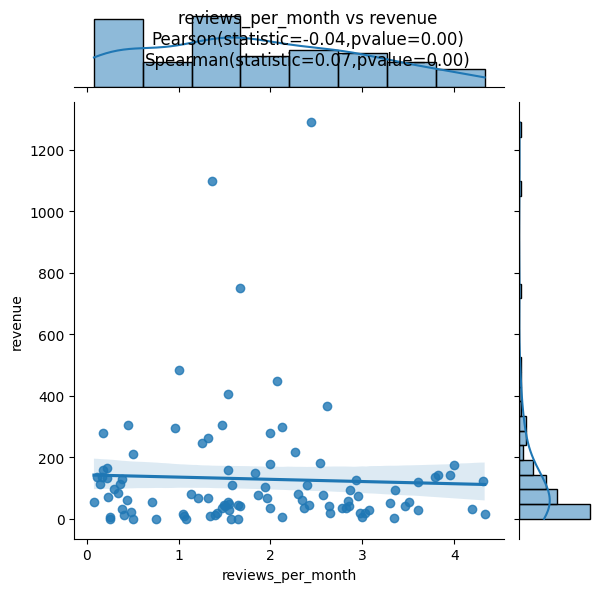

In [57]:
for col in NUMERICAL_VARIABLES:
  scat_plot = sns.jointplot(
      df[~df[col].isnull() & (df[col].between(df[col].quantile(0.05), df[col].quantile(0.95)))].sample(100),
      x=col,
      y="revenue",
      kind='reg'
  )
  df_non_null = df[~df[col].isnull()]
  pearson_col = pearsonr(df_non_null[col], df_non_null["revenue"])
  pearson_stat = pearson_col.statistic
  pearson_pvalue = pearson_col.pvalue

  spearman_col = spearmanr(df_non_null[col], df_non_null["revenue"])
  spearman_stat = spearman_col.statistic
  spearman_pvalue = spearman_col.pvalue

  scat_plot.fig.suptitle(
      f"{col} vs revenue\n"
      + f"Pearson(statistic={pearson_stat:.2f},pvalue={pearson_pvalue:.2f})\n"
      + f"Spearman(statistic={spearman_stat:.2f},pvalue={spearman_pvalue:.2f})"
  )
  plt.show()
  plt.close()

### Relación entre mejores variables cuantitativas

accomodates y beds son las variables que presentan una moderada correlación con el revenue, así que se genera un bubbleplot con tamaño de burbuja el revenue para mostrar que el crecimiento de estas dos en simultáneo afecta el revenue de manera positiva.

Como es de esperarse, ambas variables tienen una alta correlación y visualmente las propiedades de mayor revenue suelen agruparse en los valores mayores de accommodate y beds simultáneamente.

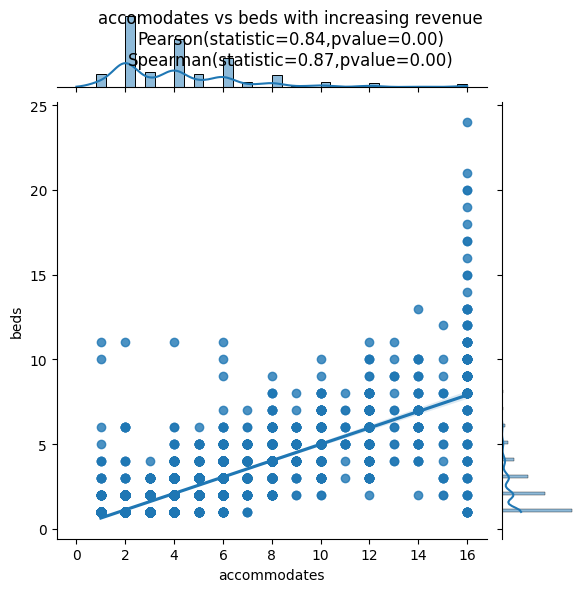

In [58]:
scat_plot = sns.jointplot(
    df,
    x="accommodates",
    y="beds",
    kind="reg"
)
df_non_null = df[(~df["accommodates"].isnull()) & (~df["beds"].isnull())]
pearson_col = pearsonr(df_non_null["accommodates"], df_non_null["beds"])
pearson_stat = pearson_col.statistic
pearson_pvalue = pearson_col.pvalue

spearman_col = spearmanr(df_non_null["accommodates"], df_non_null["beds"])
spearman_stat = spearman_col.statistic
spearman_pvalue = spearman_col.pvalue

scat_plot.fig.suptitle(
    f"accomodates vs beds with increasing revenue\n"
    + f"Pearson(statistic={pearson_stat:.2f},pvalue={pearson_pvalue:.2f})\n"
    + f"Spearman(statistic={spearman_stat:.2f},pvalue={spearman_pvalue:.2f})"
)
plt.show()
plt.close()

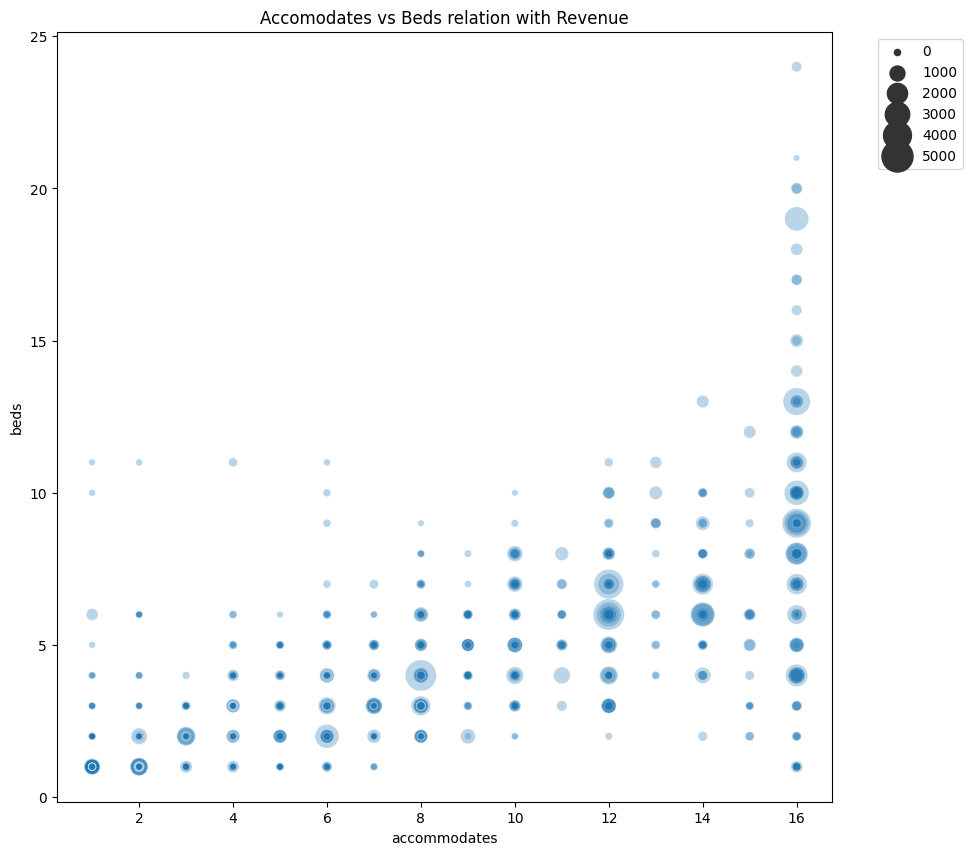

In [59]:
plt.figure(figsize=(10,10))
plt.title("Accomodates vs Beds relation with Revenue")
sns.scatterplot(
    df,
    x="accommodates",
    y="beds",
    size="revenue",
    sizes=(20, 500),
    alpha=0.3
)
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

### Relación entre variables cuantitativas y cualitativas

Se reproduce la gráfica anterior, pero separando mejores categorías de otras. Se observa inmediatamente que wifi es una necesidad básica y que los barrios y propiedades más importantes no necesariamente necesitan un número de habitaciones grande (encima de 4) para generar una ganancia encima de \$ 240 USD.

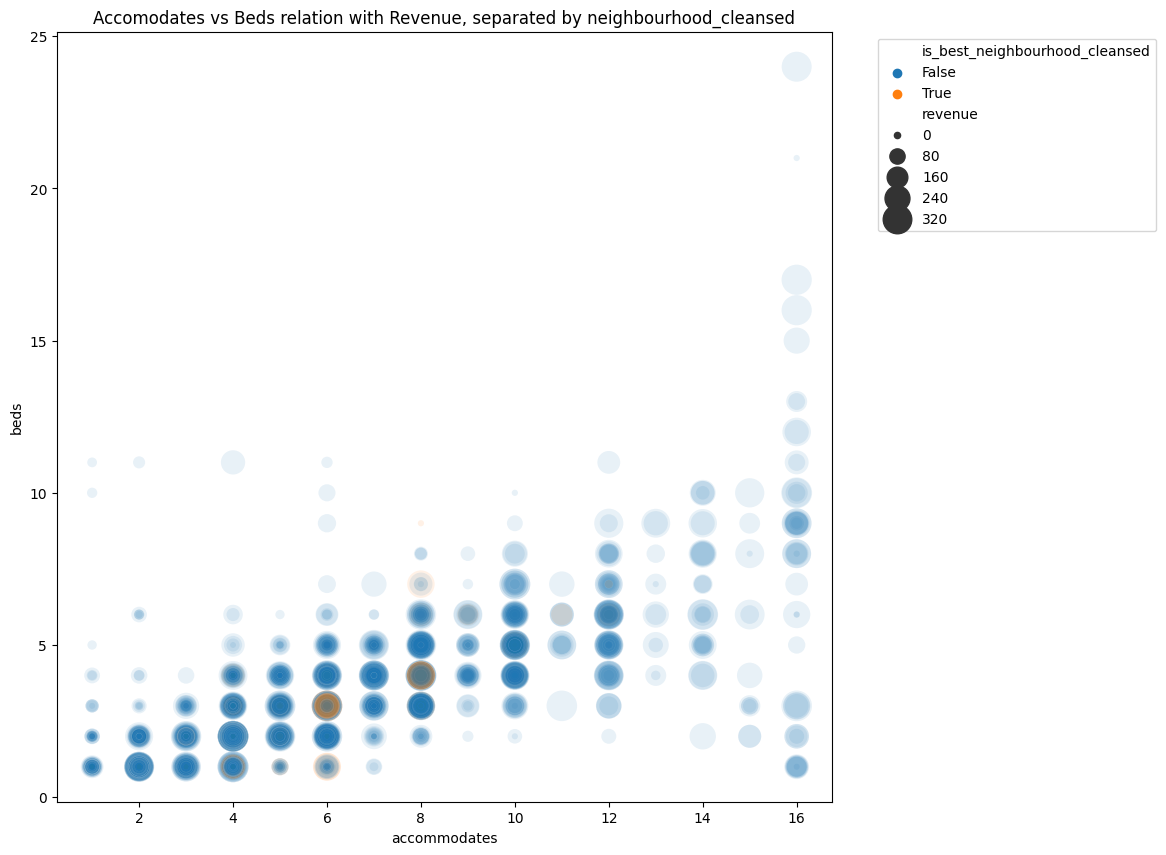

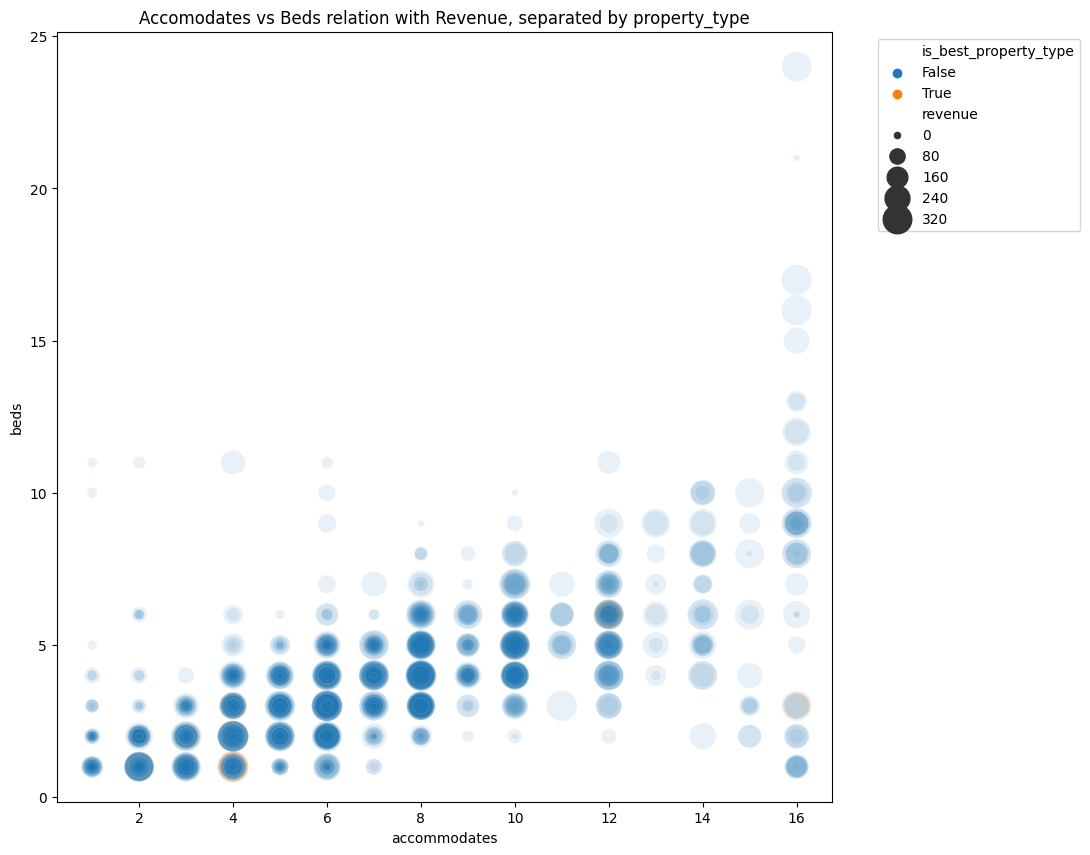

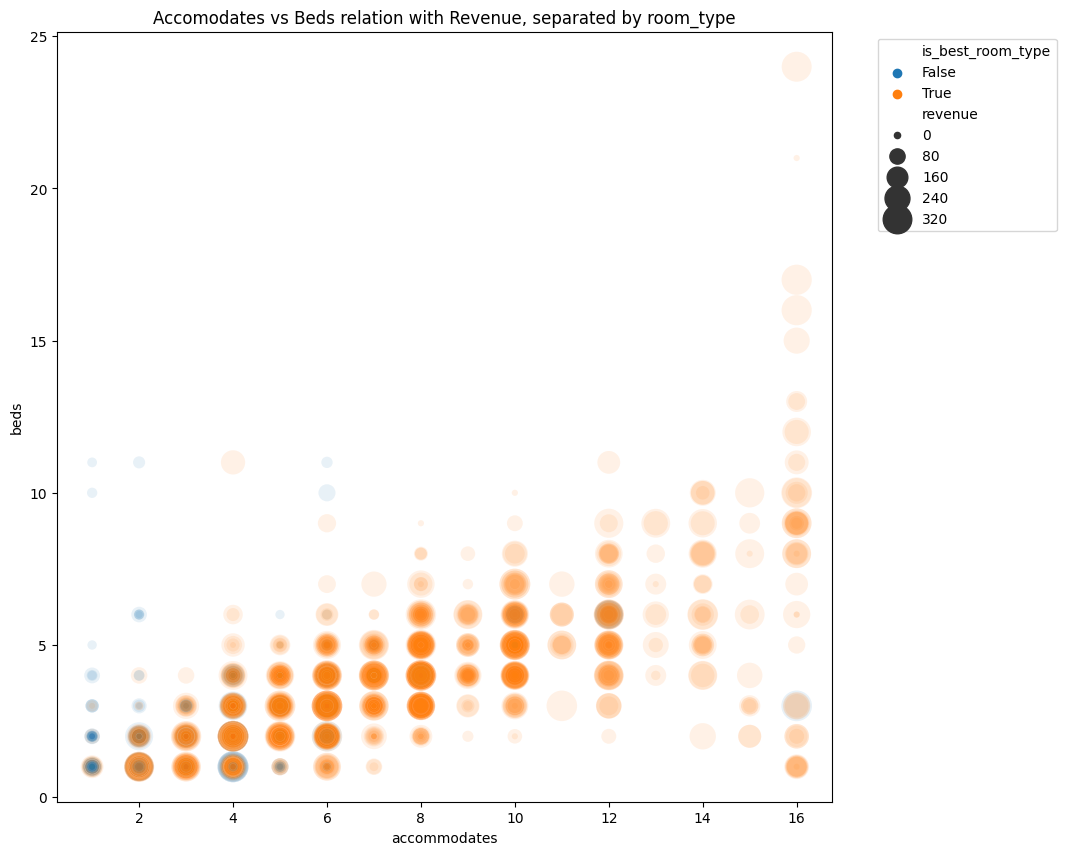

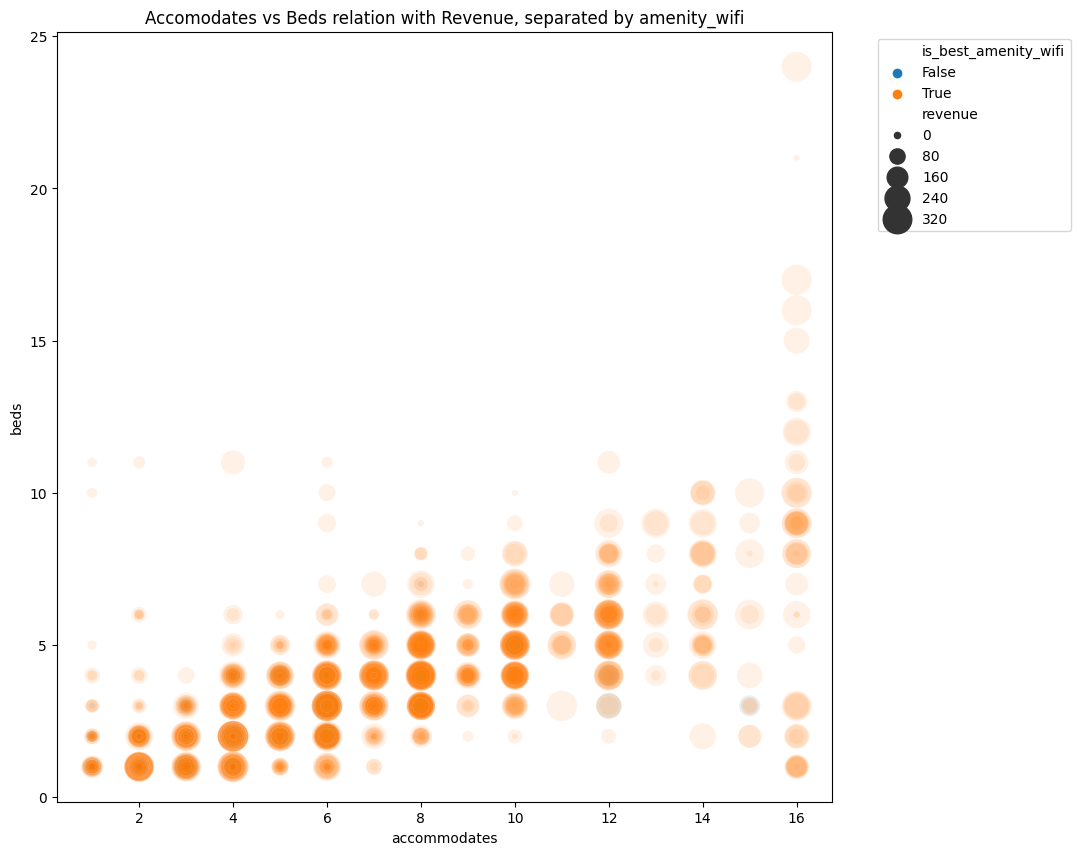

In [60]:
for col, best_cats in best_categories.items():
  df[f"is_best_{col}"] = df[col].isin(best_cats)
  plt.figure(figsize=(10,10))
  plt.title(f"Accomodates vs Beds relation with Revenue, separated by {col}")
  sns.scatterplot(
      df[df["revenue"].between(df["revenue"].quantile(0.05), df["revenue"].quantile(0.95))],
      x="accommodates",
      y="beds",
      size="revenue",
      hue=f"is_best_{col}",
      sizes=(20, 500),
      alpha=0.1
  )
  plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
  plt.show()